In [1]:
import matplotlib.pyplot as plt
from tueplots import bundles
from tueplots.constants.color import palettes, rgb
import numpy as np
import pandas as pd
import os

def turn_to_np_rgb(hex_color, coloration=1):
    return (np.array( list(bytes.fromhex(hex_color)) )/ 255.0)*coloration
PRIMARY_COLORS = [
    turn_to_np_rgb("000000"), #000000
    # turn_to_np_rgb("253494"), #253494,
    # turn_to_np_rgb("EC6634"), #EC6634
    # turn_to_np_rgb("33b983"), #33b983
    # turn_to_np_rgb("BB5566"), #BB5566
    turn_to_np_rgb("5D3E94"),  #5D3E94
    turn_to_np_rgb("33b983"), #33b983
    turn_to_np_rgb("BD22AB"), #BD22AB
    turn_to_np_rgb("4786DE"), #4786DE
]

In [2]:
data = []
for root, dirs, files in os.walk('../../dat/predictions/'):
    for file in files:
        if file.startswith('hysteresis'):
            df = pd.read_csv(os.path.join(root, file))
            data.append(df)


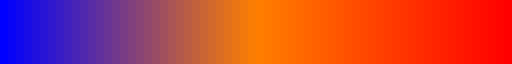

In [3]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# make color map red and blue
cmap = LinearSegmentedColormap.from_list("custom_cmap", [[0,0,1], [1,0.5,0], [1,0,0]], N=64)
models = ['c_mean', 'linreg', 'nn', 'lstm', 'kan']

for df in data:
    for model in models[1:]:
        df[f"diff_{model}"] = (df['c_mean'].rolling(8, min_periods=1).mean().abs() - df[model].rolling(16, min_periods=1).mean().abs()).abs()
        df[f"diff_{model}"].rolling(8, min_periods=1).mean()
        #df[f"diff_{model}_norm"] = (df[f"diff_{model}"] - df[f"diff_{model}"].min()) / (df[f"diff_{model}"].max() - df[f"diff_{model}"].min())
    max_diff = max([df[f"diff_{model}"].max() for model in models[1:]])
    min_diff = min([df[f"diff_{model}"].min() for model in models[1:]])
    for model in models[1:]:
        df[f"diff_{model}_norm"] = (df[f"diff_{model}"] - min_diff) / (max_diff - min_diff)
cmap

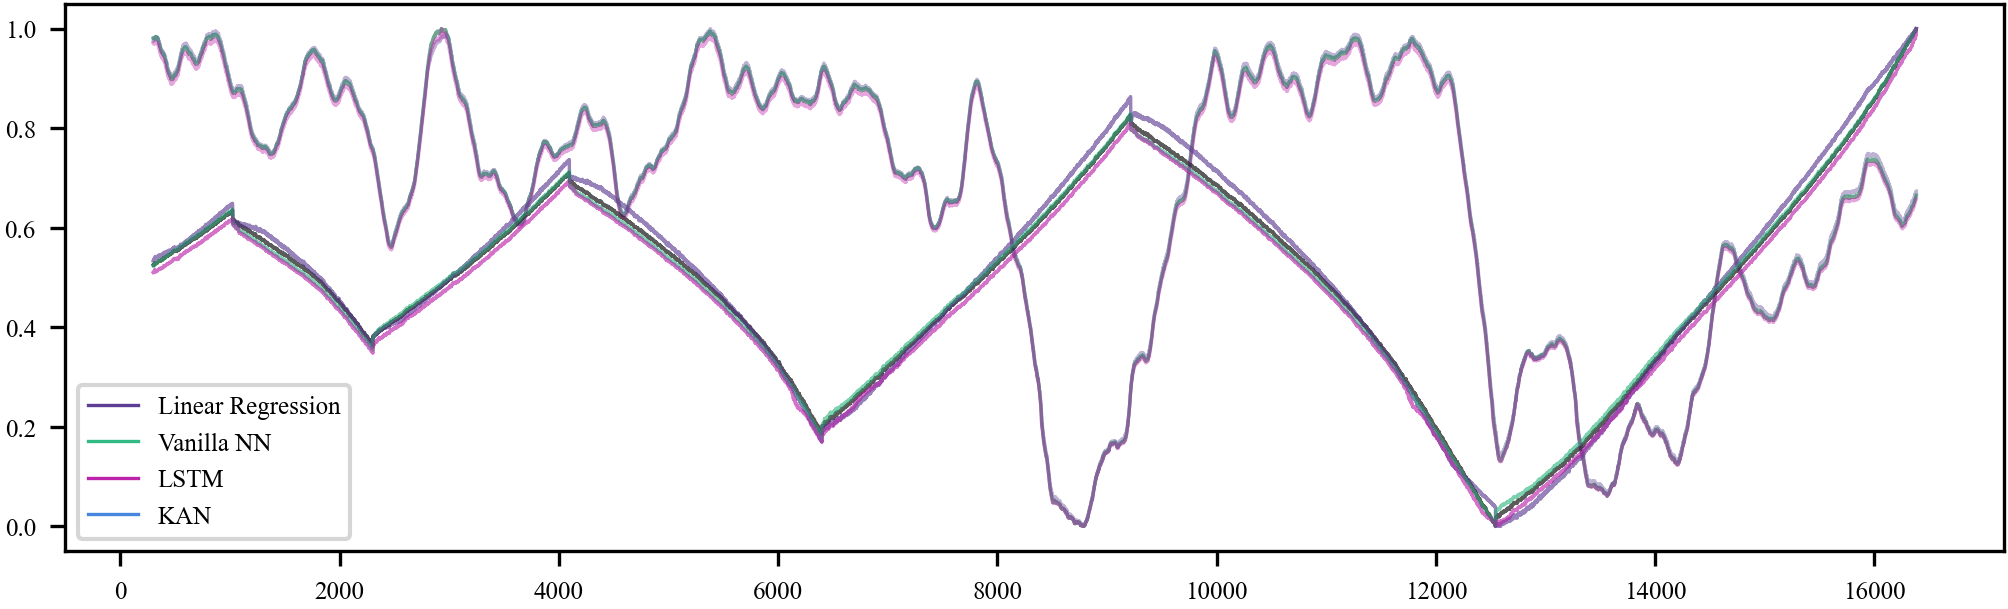

In [4]:
plt.rcParams.update({"figure.dpi": 300})
plt.rcParams.update(bundles.icml2022(column="full", family="serif", usetex=False, nrows=1, ncols=2))
plt.rcParams['font.serif'] = "Times New Roman"

cutoff = 16384

fig, ax = plt.subplots(1, 1)
msz = 0.5
lw = .8
alph = 0.4
alph_fill = 0.5

models = ['c_mean', 'linreg', 'nn', 'lstm', 'kan'][1:]
model_labels = ['Ground Truth', 'Linear Regression', 'Vanilla NN', 'LSTM', 'KAN'][1:]

#data_cut = [data[2]]
for i, df in enumerate(data):
    for j, (model, label) in enumerate(zip(models, model_labels)):
        y = df[model].iloc[:cutoff]
        y = (y - np.min(y)) / (np.max(y) - np.min(y))
        t = df.index
        #y_mean = y.iloc[:cutoff].rolling(window=1, center=True, min_periods=1).mean()
        #y_mean = y_mean - df['c_mean'].iloc[0]
        # time = df['time'].iloc[cutoff:] - df['time'].iloc[cutoff]
        time = range(len(y))
        ax.plot(time, y, color=PRIMARY_COLORS[j], lw=lw, alpha=alph)

# for each color add a patch to the legend
for j, (model, label) in enumerate(zip(models, model_labels)):
    ax.plot([], [], color=PRIMARY_COLORS[j+1], lw=lw, label=label)

# ax.set_ylabel('Drift [%]')
# ax.set_ylim(-0.055, 0.055)
# ax.set_yticks(np.arange(-0.05, 0.055, 0.01))
# ax.set_yticklabels([f'{x * 100:.0f}' for x in ax.get_yticks()])

# ax.set_xlabel('Time [min]')
# ax.set_xlim(-20, 1800)
# ax.set_xticks(np.arange(0, 1801, 300))
# ax.set_xticklabels([f'{x // 60:.0f}' for x in np.arange(0, 1801, 300)])
ax.legend()
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_7688\1021048517.py:74: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


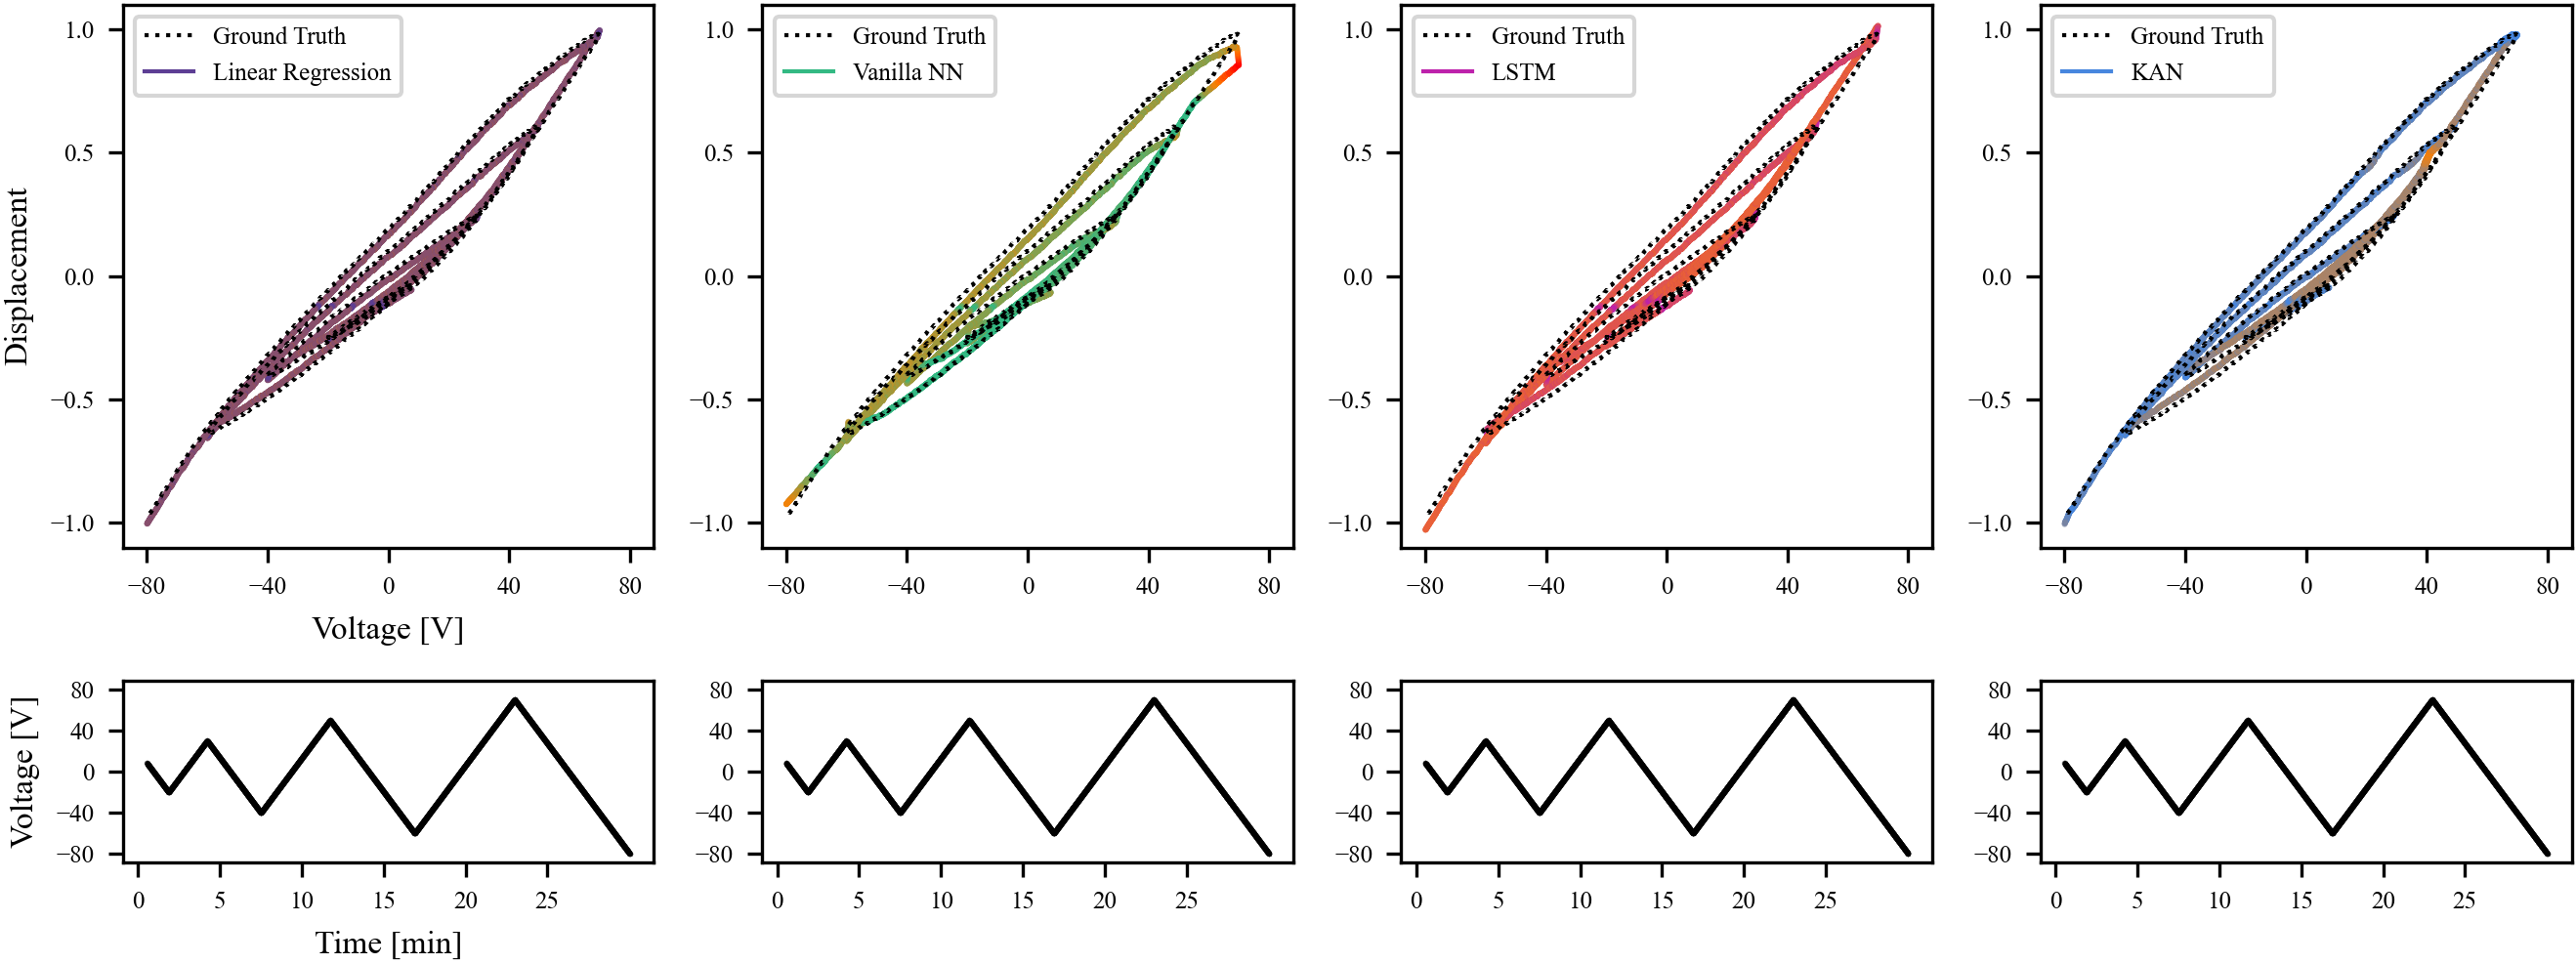

In [5]:
msz = 0.3
lw = 1
alph = .2
alph_fill = 0.5

models = ['c_mean', 'linreg', 'nn', 'lstm', 'kan']
model_labels = ['Ground Truth', 'Linear Regression', 'Vanilla NN', 'LSTM', 'KAN']

fig, axs = plt.subplots(2, 4, height_ratios=[3, 1], figsize=(9, 3.5))

for i, df in enumerate(data[:1]):
    for j, (model, label) in enumerate(zip(models[1:], model_labels[1:])):
        if model == 'c_mean':
            continue
        
        y = df[model].dropna()
        x = df['finestep'].loc[y.index]  
        gt = df['c_mean']
        ma, mi = gt.max(), gt.min()
        gt = 2 * (gt - gt.min()) / (gt.max() - gt.min()) - 1
        gt = gt.loc[y.index]

        y = 2 * (y - mi) / (ma - mi) - 1
        x = x / np.power(2, 16) * 160
        ax = axs[0, j % 4]

        # plot normaly with a line and color
        # ax.plot(x, -y.rolling(16).mean(), linewidth=1.5, alpha=1, ls='-', color=PRIMARY_COLORS[j], label=label)
        # ax.plot(x, -gt.rolling(16).mean(), linewidth=lw, alpha=alph, ls='dotted', color=PRIMARY_COLORS[0], label='Ground Truth')


        # # pülot using scatter plot with custom color map based on the difference
        ax.plot(x, -gt.rolling(16).mean(), linewidth=lw, alpha=1, ls='dotted', color='black', label='Ground Truth')
        ax.scatter(list(x)+[-100], list(-y.rolling(16).mean()) + [-100], c=list(df[f"diff_{model}_norm"].loc[y.index]) + [1],
                   #cmap= LinearSegmentedColormap.from_list("custom_cmap", [PRIMARY_COLORS[j],PRIMARY_COLORS[j], [1,0.5,0], [1,0,0]], N=32) if model not in ['linreg', 'lstm'] else LinearSegmentedColormap.from_list("custom_cmap", [PRIMARY_COLORS[j],PRIMARY_COLORS[j],PRIMARY_COLORS[j],PRIMARY_COLORS[j], [1,0.5,0],[1,0,0]], N=32),
                   cmap= LinearSegmentedColormap.from_list("custom_cmap", [PRIMARY_COLORS[j+1], [1,0.5,0], [1,0,0]], N=16),
                   s=0.2, alpha=0.66)
        ax.plot([], [], color=PRIMARY_COLORS[j+1], lw=1, label=label)

        ax.set_xlim(-88, 88)
        ax.set_ylim(-1.1, 1.1)
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_xticks([-80, -40, 0, 40, 80])
        ax.legend()

        ax2 = axs[1, j % 4]
        ax2.plot(x, marker='o', markersize=msz, linewidth=lw, alpha=alph, ls='-', color='black')
        ax2.set_ylim(-88, 88)
        ax2.set_yticks([-80, -40, 0, 40, 80])
        ax2.set_xticks(np.arange(0, len(x), 60*5/0.11))
        ax2.set_xticklabels([f'{x * 0.11 / 60:.0f}' for x in ax2.get_xticks()])

        # remove y-axis labels for all but the first plot
        if j == 0:
            ax.set_ylabel('Displacement')
            ax2.set_ylabel('Voltage [V]')
            # pad to the right
            ax.set_xlabel('Voltage [V]')
            ax2.set_xlabel('Time [min]')
        if j == 1:
            pass
            # ax.set_xlabel('Voltage [V]')
            # ax2.set_xlabel('Time [min]')
        if i % 4 != 0:
            ax.set_yticklabels([])
            ax2.set_yticklabels([])

#fig.text(0.5, 0, 'Time', ha='center')
#fig.text(0, 0.66, 'Displacement', va='center', rotation='vertical')
#fig.text(0.5, 0.2, 'Voltage', va='center')



plt.tight_layout()
plt.savefig('./fig_hysteresis_eval.pdf')
plt.show()

0


C:\Users\David\AppData\Local\Temp\ipykernel_7688\2575342116.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


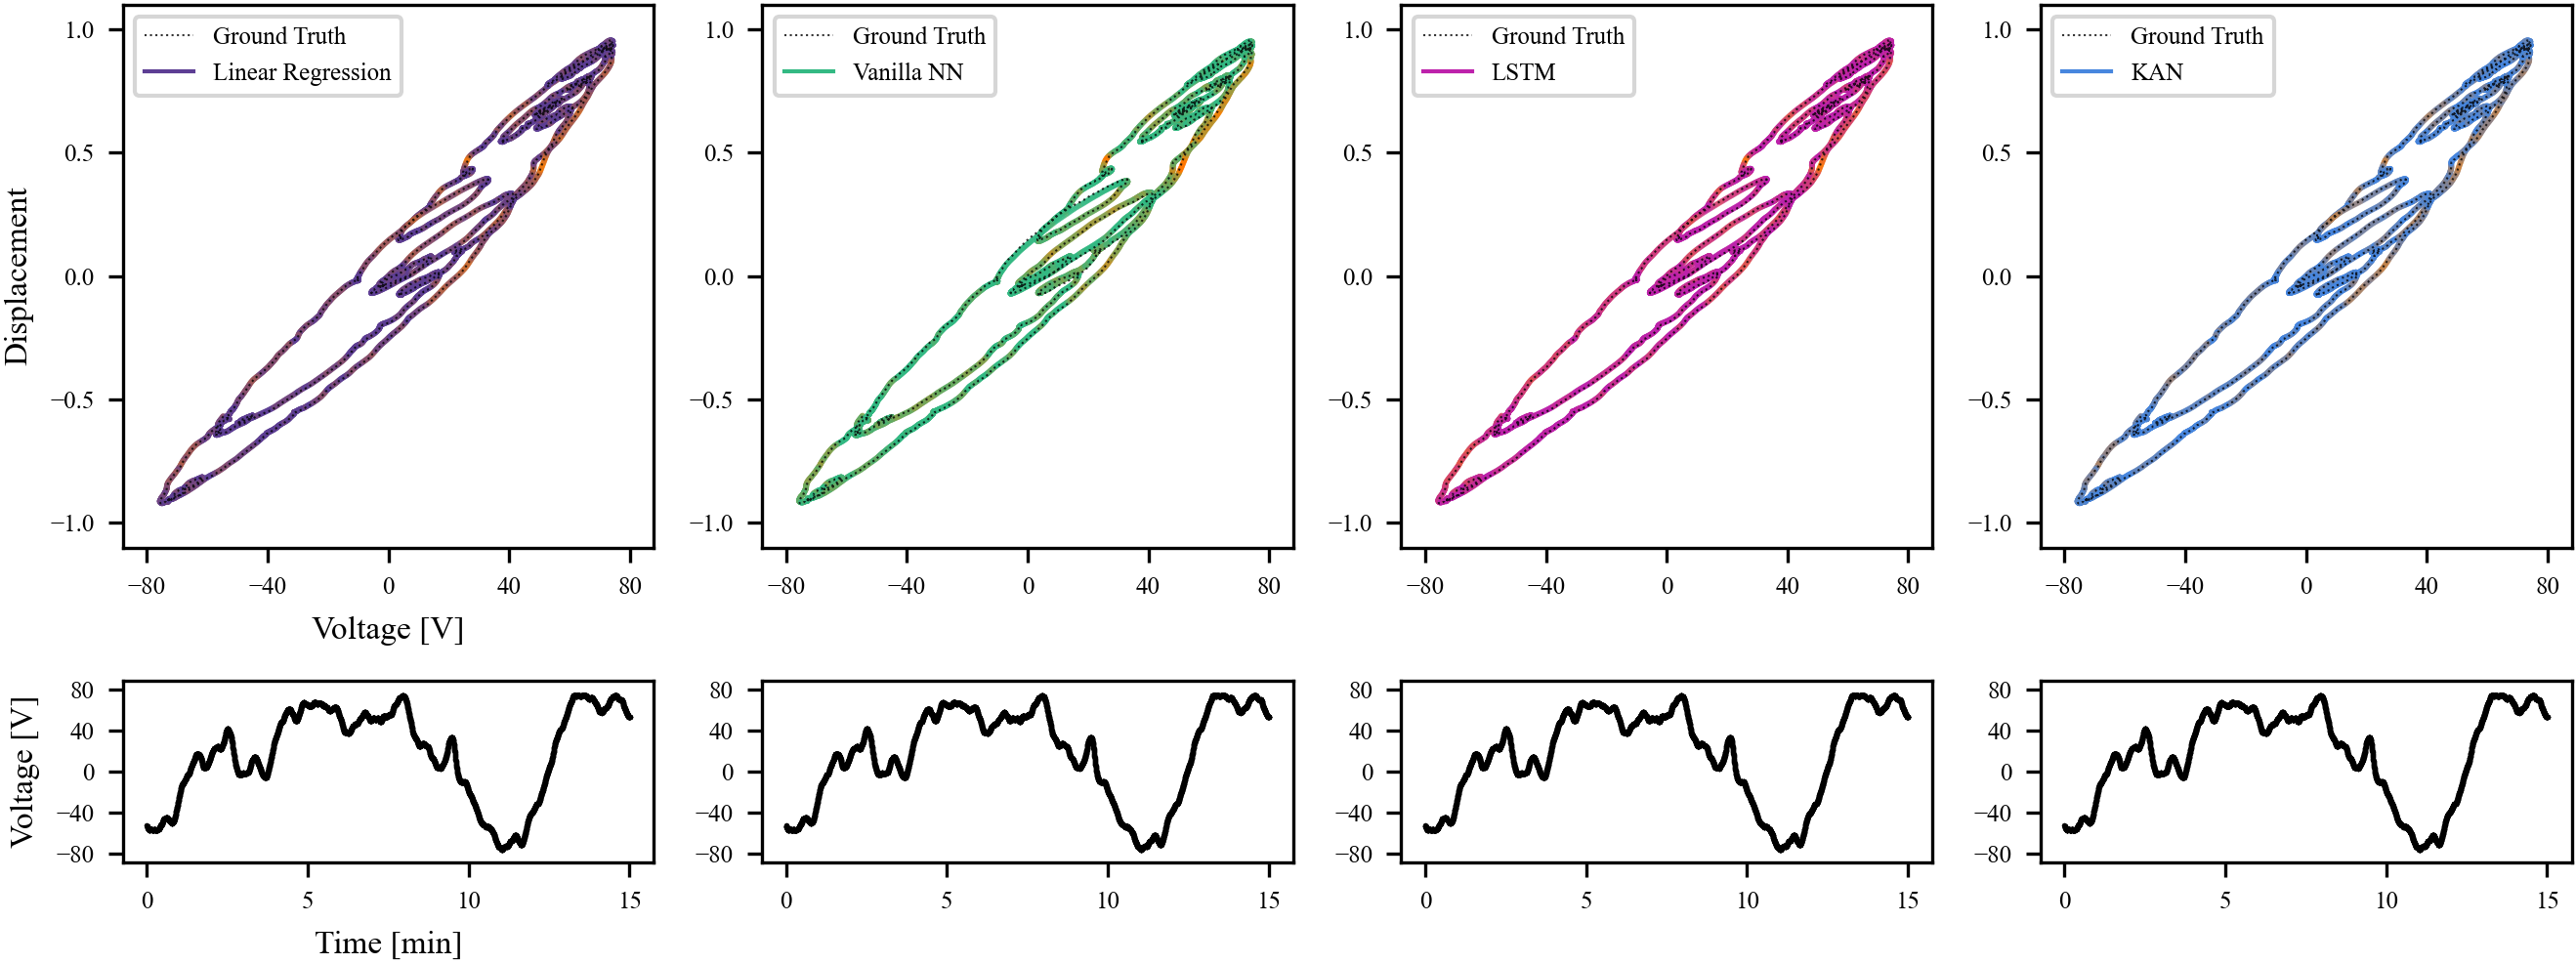

In [6]:
msz = 0.3
lw = .5
alph = .8
alph_fill = 0.5

offset = 24000
cutoff = int(16384/2) + offset


models = ['c_mean', 'linreg', 'nn', 'lstm', 'kan']
model_labels = ['Ground Truth', 'Linear Regression', 'Vanilla NN', 'LSTM', 'KAN']

fig, axs = plt.subplots(2, 4, height_ratios=[3, 1], figsize=(9, 3.5))

for i, df in enumerate([data[1]]):
    print(i)
    for j, (model, label) in enumerate(zip(models[1:], model_labels[1:])):
        if model == 'c_mean':
            continue
        gt = df['c_mean']
        ma, mi = gt.max(), gt.min()

        y = df[model]
        y = y[offset:cutoff].dropna()
        y = 2 * (y - mi) / (ma - mi) - 1
        x = df['finestep'].loc[y.index]  
        
        gt = 2 * (gt - mi) / (ma - mi) - 1
        gt = gt.loc[y.index]

        x = x / np.power(2, 16) * 160
        ax = axs[0, j % 4]
        # ax.plot(x, -y.rolling(16).mean(), linewidth=1.5, alpha=1, ls='-', color=PRIMARY_COLORS[j], label=label)
        # ax.plot(x, -gt.rolling(16).mean(), linewidth=lw, alpha=alph, ls='dotted', color=PRIMARY_COLORS[0], label='Ground Truth')

        # plot using scatter plot with custom color map based on the difference
        ax.plot(x, -gt.rolling(16).mean(), linewidth=lw, alpha=alph, ls='dotted', color='black', label='Ground Truth')
        ax.scatter(list(x)+[-100], list(-y.rolling(16).mean()) + [-100], c=list(df[f"diff_{model}_norm"].loc[y.index]) + [1],
                   cmap= LinearSegmentedColormap.from_list("custom_cmap", [PRIMARY_COLORS[j+1],[1,0.5,0], [1,0,0]], N=16),
                   s=0.2, alpha=0.66)
        ax.plot([], [], color=PRIMARY_COLORS[j+1], lw=1, label=label)

        ax.set_title(label)
        ax.set_xlim(-88, 88)
        ax.set_ylim(-1.1, 1.1)
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_xticks([-80, -40, 0, 40, 80])
        ax.legend()
        x.reset_index(drop=True, inplace=True)
        ax2 = axs[1, j % 4]
        ax2.plot(x, marker='o', markersize=msz, linewidth=lw, alpha=alph, ls='-', color='black')
        ax2.set_ylim(-88, 88)
        ax2.set_yticks([-80, -40, 0, 40, 80])
        ax2.set_xticks(np.arange(0, len(x), 60*5/0.11))
        ax2.set_xticklabels([f'{x * 0.11 / 60:.0f}' for x in ax2.get_xticks()])

        # remove y-axis labels for all but the first plot
        if j == 0:
            ax.set_ylabel('Displacement')
            ax2.set_ylabel('Voltage [V]')
            # pad to the right
            ax.set_xlabel('Voltage [V]')
            ax2.set_xlabel('Time [min]')
        if j == 1:
            pass
            # ax.set_xlabel('Voltage [V]')
            # ax2.set_xlabel('Time [min]')
        if i % 4 != 0:
            ax.set_yticklabels([])
            ax2.set_yticklabels([])

#fig.text(0.5, 0, 'Time', ha='center')
#fig.text(0, 0.66, 'Displacement', va='center', rotation='vertical')
#fig.text(0, 0.2, 'Voltage', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig('./fig_hysteresis_eval2.pdf')
plt.show()